## Zillow Clustering Exercises

In [1]:
# Imports necessary to acquire, prepare, explore, visualize, analyze, and model data

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire
import prepare

from tabulate import tabulate
from IPython.display import Markdown, display

from math import sqrt
from scipy import stats

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

np.random.seed(123)

### Acquire & Summarize 

In [2]:
df = acquire.get_zillow_data()
# this is a user-defined function in acquire.py that pulls in selected data from the SQL database

In [3]:
df.info()

# 52441 before wrangling

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52441 non-null  int64  
 1   logerror                      52441 non-null  float64
 2   transactiondate               52441 non-null  object 
 3   taxvaluedollarcnt             52440 non-null  float64
 4   bedroomcnt                    52441 non-null  float64
 5   bathroomcnt                   52441 non-null  float64
 6   yearbuilt                     52325 non-null  float64
 7   fips                          52441 non-null  float64
 8   calculatedfinishedsquarefeet  52359 non-null  float64
 9   latitude                      52441 non-null  float64
 10  longitude                     52441 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 4.4+ MB


In [4]:
df.isna().sum().sum() /len(df)
# returns percentage of nulls in df

0.0037947407562784843

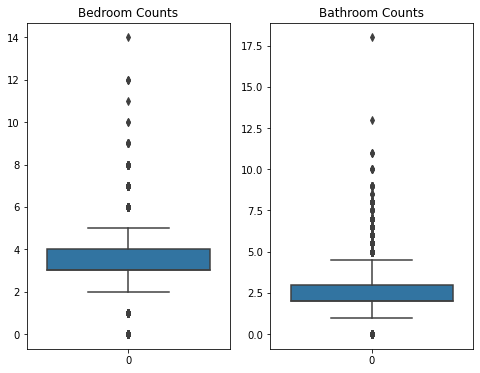

In [5]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize = (8, 6))
# sets parameters of graphs

sns.boxplot(data=df.bedroomcnt,  orient='v' , ax=axes[0]).set(title='Bedroom Counts')
sns.boxplot(data=df.bathroomcnt,  orient='v' , ax=axes[1]).set(title = 'Bathroom Counts')

plt.show()

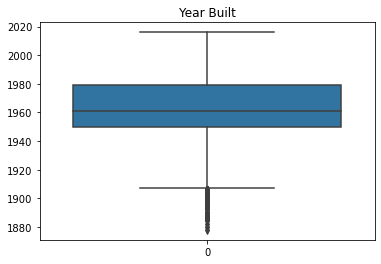

In [6]:
figsize = (8, 6)

sns.boxplot(data=df.yearbuilt,  orient='v').set(title = 'Year Built')

plt.show()

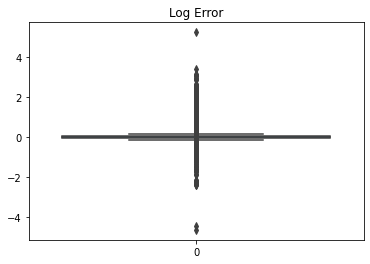

In [7]:
figsize = (8, 6)

sns.boxplot(data=df.logerror,  orient='v').set(title = 'Log Error')

plt.show()

(array([2.0000e+00, 0.0000e+00, 2.6000e+01, 1.0900e+02, 5.0948e+04,
        1.2210e+03, 7.6000e+01, 5.7000e+01, 1.0000e+00, 1.0000e+00]),
 array([-4.65542038, -3.66357847, -2.67173657, -1.67989467, -0.68805277,
         0.30378914,  1.29563104,  2.28747294,  3.27931484,  4.27115675,
         5.26299865]),
 <BarContainer object of 10 artists>)

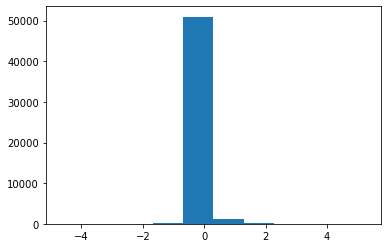

In [8]:
plt.hist(df.logerror)

In [9]:
df.logerror.quantile(.99), df.logerror.quantile(.01)
#will use in addition to visual to help remove outliers for now

(0.5479474460907992, -0.32637269461880003)

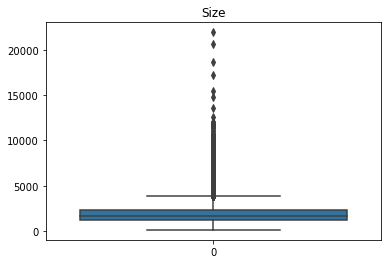

In [10]:
figsize = (8, 6)

sns.boxplot(data=df.calculatedfinishedsquarefeet,  orient='v').set(title = 'Size')

plt.show()

In [11]:
df.calculatedfinishedsquarefeet.quantile(.99), df.calculatedfinishedsquarefeet.quantile(.01)

(5500.0, 694.58)

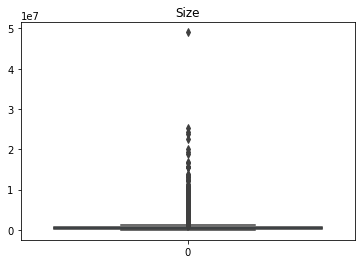

In [12]:
figsize = (8, 6)

sns.boxplot(data=df.taxvaluedollarcnt,  orient='v').set(title = 'Size')

plt.show()

### Decisions-
- Nulls: Bc the % of nulls is incredibly low, dropping all null records will be part of the data prep
- datatypes- taxvaluedollarcnt, yearbuilt, fips, squarefeet can be converted to int
- lat and long forms need to be corrected
- rename columns
- other decisions in prepare function

In [13]:
df = prepare.prepare_zillow(df)

In [14]:
df

,parcelid,log_error,transaction_date,tax_value,bedrooms,bathrooms,year_built,fips,square_feet,latitude,longitude,county
0,14297519,0.025595,2017-01-01,1023282,4.0,3.5,1998,6059,3100,33634931.0,-117869207.0,orange
1,17052889,0.055619,2017-01-01,464000,2.0,1.0,1967,6111,1465,34449266.0,-119281531.0,ventura
2,14186244,0.005383,2017-01-01,564778,3.0,2.0,1962,6059,1243,33886168.0,-117823170.0,orange
3,12177905,-0.103410,2017-01-01,145143,4.0,3.0,1970,6037,2376,34245180.0,-118240722.0,los_angeles
4,12095076,-0.001011,2017-01-01,773303,4.0,3.0,1950,6037,2962,34145202.0,-118179824.0,los_angeles
...,...,...,...,...,...,...,...,...,...,...,...,...
52436,12412492,0.001082,2017-09-19,346534,4.0,2.0,1962,6037,1633,33870815.0,-118070858.0,los_angeles
52437,11000655,0.020615,2017-09-20,354621,2.0,2.0,1940,6037,1286,34245368.0,-118282383.0,los_angeles
52438,17239384,0.013209,2017-09-21,67205,4.0,2.0,1964,6111,1612,34300140.0,-118706327.0,ventura
52439,12773139,0.037129,2017-09-21,49546,3.0,1.0,1954,6037,1032,34040895.0,-118038169.0,los_angeles


In [16]:
47981/52441
#how much data do we still have after wrangling?

0.9149520413416983

In [17]:
df.parcelid.nunique()

47884